# Описание

- Датасет взят отсюда https://media.xiph.org/video/derf/. Насколько удалось разузнать, в RnD по видеокомпрессии он часто используется для бенчмаркинга алгоритмов. Можем использовать. Внизу есть разные варианты датасетов, для тестов взял objective-1-fast. 

- Данные в raw формате yuv420 (.y4m, в отличии от .yuv, есть хедер с метаданными). Ссылки: https://ru.wikipedia.org/wiki/YUV, 

- Используется opencv-python для загрузки-обработки-сохранения видео.

- В качестве backend-а для i/o используется библиотека ffmpeg. Бинарники для винды лежат в корне проекта. Для Linux-а нужно ставить отдельно.

- На текущий момент не нашел способа сохранять видео обратно в .y4m. Нужно использовать расширение .avi для сохраняемого файла. Иначе все сломается. При этом формат хранения фреймов видео останется прежним. Есть небольшая разница в размерах файла, но она незначительна. Далее будет проверка, что данные, загружаемые из .y4m и .avi одинаковы (одинаковые массивы np.ndarray при выгрузке). Это не всегда выполняется, есть потери. Почему - надо разбираться. В целом, различие минимально, не должно сильно влиять на результат.

Полезные ссылки:
1. https://habr.com/ru/company/erlyvideo/blog/317494/

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
plt.rcParams['animation.ffmpeg_path'] = r'ffmpeg/bin/ffmpeg.exe'
from matplotlib import animation
from IPython.display import HTML


def play_video(video: np.array, fps: int = 30):
    """
    Plays video specified in np.array
    Input:
    :param: video - np.array [frames, height, width, channels] - RGB uint8
    :param: fps - fps :)
    """
    fig = plt.figure(figsize=(12,6))
    im = plt.imshow(video[0,:,:,:])
    plt.close() # this is required to not display the generated image

    def init():
        im.set_data(video[0,:,:,:])

    def animate(i):
        im.set_data(video[i,:,:,:])
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                                   interval=1000.0 / fps)
    return HTML(anim.to_html5_video())

In [ ]:
LOAD_FNAME = "data//red_kayak_360p_60f.y4m"
SAVE_FNAME = "data//red_kayak_360p_60f.avi"

### 1. Загрузка видео в массив numpy

In [ ]:
from cvtcomp.utils import load_video_to_numpy, save_video_from_numpy

video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)

### 2. Модифицирование видео (тест)

In [ ]:
modified_video = video.copy() 
modified_video[:,256:768,256:768,:] = 255

 Так можно посмотреть на fourcc исходного видео

In [ ]:
import struct

print("FOURCC is '%s'" % struct.pack("<I", int(fourcc)))

### Визуализация

In [ ]:
%matplotlib inline

play_video(video, fps=20)

In [ ]:
modified_video = video.copy() 

modified_video[:,100:200,100:200,:] = 255

play_video(modified_video, fps=20)

### 3. Сохранение видео

In [ ]:
save_video_from_numpy(SAVE_FNAME, modified_video, fourcc, fps, size, color=True)

### 4. Тесты на потери при загрузки/сохранении

In [ ]:
video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)
save_video_from_numpy(SAVE_FNAME, video, fourcc, fps, size, color=True)
video_new, _, _, _ = load_video_to_numpy(SAVE_FNAME) 

print(f"RMSE: {(((video_new - video)**2).sum() / video_new.size)**0.5}")

In [ ]:
print(f"PSNR = {cv2.PSNR(video_new, video)} dB")

video.shape

[Wikipedia](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio): Typical values for the PSNR in lossy image and video compression are between 30 and 50 dB, provided the bit depth is 8 bits, where higher is better. 

__Вывод:__ Нужно смотреть, из за чего возникают потери (вообще, переход из yuv420 в rgb и обратно может приводить к ним)

In [ ]:
play_video(np.abs(video-video_new))

In [ ]:
play_video(video)

In [ ]:
play_video(video_new)

# New tests

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
plt.rcParams['animation.ffmpeg_path'] = r'ffmpeg/bin/ffmpeg.exe'
from matplotlib import animation
from IPython.display import HTML
from tensorly.decomposition import tucker
from tensorly import tucker_to_tensor

import tensorly as tl

from cvtcomp.base import Encoder, Decoder
from cvtcomp.utils import load_video_to_numpy, save_video_from_numpy, compute_metrics_dataset


def encdec_video_chunkwise(video, encoder, decoder, chunk_size=10):
    decompressed_video = np.zeros(video.shape, dtype=np.uint8)
    
    for ii in range(0, video.shape[0], chunk_size):
        compressed_chunk = encoder.encode(video[ii: ii + chunk_size, :, :, :])
        decompressed_video[ii: ii + chunk_size, :, :, :] = decoder.decode(compressed_chunk)
    
    return decompressed_video

def tucker_compress(video, depth=100, frames_chunk=10, rank=(2, 200, 200, 2)):
    compressed_video = np.zeros_like(video, dtype=float)
    # print(compressed_video.dtype)
    for frame_no in range(0, video.shape[0], frames_chunk):
        picture = video[frame_no:frame_no+frames_chunk,:,:,:].astype(np.float64)
        X = tl.tensor(picture)
        # print(X.shape)
        core, factors = tucker(X, rank=rank)
        # print(core.shape)
        # print(factors)
        compressed_video[frame_no:frame_no+frames_chunk,:,:,:] = tl.tucker_to_tensor((core, factors))

    compressed_video[compressed_video>255.0] = 255.0
    compressed_video[compressed_video<0.0] = 0.0
    compressed_video = compressed_video.astype(np.uint8)    
    return compressed_video


def play_video(video: np.array, fps: int = 30):
    """
    Plays video specified in np.array
    Input:
    :param: video - np.array [frames, height, width, channels] - RGB uint8
    :param: fps - fps :)
    """
    fig = plt.figure(figsize=(12,6))
    im = plt.imshow(video[0,:,:,:])
    plt.close() # this is required to not display the generated image

    def init():
        im.set_data(video[0,:,:,:])

    def animate(i):
        im.set_data(video[i,:,:,:])
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                                   interval=1000.0 / fps)
    return HTML(anim.to_html5_video())


def plot_psnr(folderpath:str, t_type="tt", Q=[0.05, 0.1, 0.2, 0.4]):
    
    result = []

    for q in Q:
        encoder = Encoder(encoder_type=t_type, quality=q)
        decoder = Decoder(decoder_type=t_type)
        print(f"quality = {q}")
        result.append(compute_metrics_dataset(folderpath, encoder, decoder, metric="psnr"))

    result = np.array(result)
    psnr = result[:, 0]
    cr = result[:, 1]

    plt.figure(figsize=(8, 6))
    plt.grid(True)
    plt.xlabel("Compression ratio, %")
    plt.ylabel("PSNR, dB")
    plt.plot(cr * 100, psnr, "r.:")

In [2]:
LOAD_FNAME = "data//red_kayak_360p_60f.y4m"

encoder = Encoder(encoder_type="tt", quality=0.4)
decoder = Decoder(decoder_type="tt")

video, fourcc, fps, size = load_video_to_numpy(LOAD_FNAME)

video.shape

(60, 360, 640, 3)

In [3]:
compressed_video = encoder.encode(video)

In [4]:
compressed_video[1][0].shape

(360, 144)

In [5]:
decompressed_video = decoder.decode(compressed_video)
#decompressed_video_chw = encdec_video_chunkwise(video, encoder, decoder, chunk_size=10)
#decompressed_video_chw_tst = tucker_compress(video, rank=(2, 72, 128, 3))

In [6]:
cv2.PSNR(video, decompressed_video)

22.52843717172364

In [7]:
#cv2.PSNR(video, decompressed_video_chw)

In [8]:
#cv2.PSNR(video, decompressed_video_chw_tst)

In [9]:
compute_metrics_dataset("data", encoder, decoder, metric="psnr")

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.36s/it]


(24.51528270651831, 0.08672005208333333)

In [21]:
play_video(video, fps=20)

In [22]:
play_video(decompressed_video, fps=20)

In [ ]:
%matplotlib inline
N = 58
plt.imshow(video[N, ..., 0] - decompressed_video[N, ..., 0])
plt.colorbar()

In [23]:
sum([x.nbytes for x in compressed_video]) / video.nbytes

0.29347395833333334

quality = 0.05


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [02:22<00:00,  4.77s/it]


quality = 0.16666666666666669


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [05:50<00:00, 11.69s/it]


quality = 0.2833333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [10:25<00:00, 20.85s/it]


quality = 0.4


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [13:10<00:00, 26.36s/it]


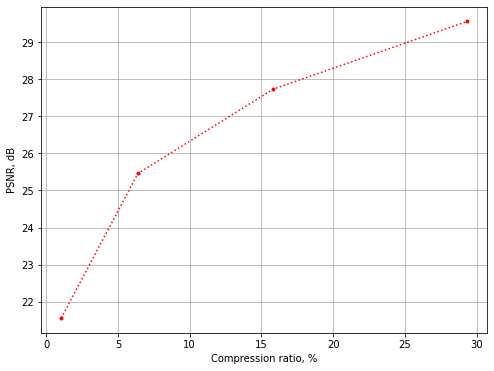

In [27]:
Q = np.linspace(0.05, 0.4, 4)     

plot_psnr("data", t_type="tt", Q=Q)